In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
STATIC_PATH = '/home/elinha/NLP/moducon_data/phase_2'

china_file_name = 'intern_review_china.csv'
japan_file_name = 'intern_review_japan.csv'
korea_file_name = 'intern_review_korea.csv'
northAmerica_file_name = 'intern_review_northAmerica.csv'
color_list = ['FFFF00', 'BC002D', '0F64CD', 'B31942']
file_name_list = [china_file_name, japan_file_name, korea_file_name, northAmerica_file_name]
df_dict = {
    file_name.split('_')[-1].split('.')[0] : {
        "dataframe" : pd.read_csv(os.path.join(STATIC_PATH,file_name)),
        "color" : color
    }
    for color, file_name in zip(color_list, file_name_list)
    }

/tmp/ipykernel_2774668/1882730640.py:11: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  "dataframe" : pd.read_csv(os.path.join(STATIC_PATH,file_name)),


# Preprocessing Strategy

1. Expand contractions : pycontractions
2. lowercase
3. change numbers to words : inflect
4. Remove Punctuations : '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'
5. Remove remained emoji, japanese, chinese, korean words
6. PoS_tagging: from nltk import pos_tag
7. If needed, remove PRP, TO, DT, etc. 
8. Stemming: PorterStemmer
9. Find out average sentence length
10. Wordcloud


In [41]:
# target_df 지정
target_country = 'northAmerica'
target_df = df_dict[target_country]['dataframe']
if target_country == 'northAmerica':
    target_df = target_df.rename(columns = {'splited_sentence': 'SeparatedSentences'})

In [52]:
target_df = pd.DataFrame()
for target_country in ['korea', 'japan', 'china']:
    df = df_dict[target_country]['dataframe']
    if target_country == 'northAmerica':
        df = df.rename(columns = {'splited_sentence': 'SeparatedSentences'})
    target_df = pd.concat([target_df, df])

target_country = 'orient'

In [53]:
target_country = 'orient'

df_dict[target_country] = {}
df_dict[target_country]['dataframe'] = target_df
df_dict[target_country]['color'] = 'ff7f00'

In [145]:
len(df_dict)

5

In [54]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import wordnet as wn



# 필요한 NLTK 데이터 다운로드
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.help.upenn_tagset('WRB')

from nltk.data import load
tagdict = load('help/tagsets/upenn_tagset.pickle')
tagdict.keys()

#remain only nouns and adjectives
include_tags = ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS']

 
from gensim.models import Word2Vec

WRB: Wh-adverb
    how however whence whenever where whereby whereever wherein whereof why


[nltk_data] Downloading package wordnet to /home/elinha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/elinha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/elinha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /home/elinha/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [55]:
target_df = target_df.dropna(subset=['SeparatedSentences'])

# Pycontractions doesn't work due to dependency issue. I just modulized it by myself.

from contractions import expand_contractions

contracted_list = []
Sentences = target_df['SeparatedSentences'].copy()

for sentence in Sentences:
    expanded_sentence = expand_contractions(sentence)
    contracted_list.append(expanded_sentence)
    
# Transform all sentences into lower case! easy!
contracted_list = [text.lower() for text in contracted_list]

# Change numbers into words
import inflect
p = inflect.engine()

# 아라비아 숫자를 텍스트 숫자로 변경 5 -> five
def replace_number(match):
    number = match.group()
    return p.number_to_words(number)
    
def convert_number(text):
    converted_text = re.sub(r'\d+', replace_number, text)
    return converted_text

inflected_list = []
inflected_list = [convert_number(text) for text in contracted_list]      

# Remove punctuations
rm_punctionations = inflected_list.copy()

def rm_punct(text):
    cleaned_text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\]。^_`{|}…~]', ' ', text)
    return cleaned_text

rm_punctionations = [rm_punct(text) for text in rm_punctionations]   


# remove japanese, korean, chinese words

def only_english(text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return cleaned_text

rm_punctionations = [only_english(text) for text in rm_punctionations]


# POS_tagging


# Text를 단어 토큰과 POS 태그로 변환
def pos_tagging(text):
    word_tokens = word_tokenize(text)
    return pos_tag(word_tokens)

tag_sentence = rm_punctionations.copy()

tag_sentence = [pos_tagging(text) for text in tag_sentence]


def remain_specific_tags(tagged_sentence, include_tags):
    return [word for word, tag in tagged_sentence if tag in include_tags]

tag_rm = tag_sentence.copy()
tag_rm = [remain_specific_tags(text, include_tags) for text in tag_rm]
tag_rm_sentence = [pos_tag(sentence) for sentence in tag_rm]

# Lemmatize & remove stopwords


# inflect engine initialize
p = inflect.engine()

# WordNetLemmatizer initialize
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    else:
        return None

def singularize_and_lemmatize(tagged_words):
    new_words = []
    
    for word, tag in tagged_words:
        if tag.startswith('N'):
            singular_word = p.singular_noun(word)
            if singular_word:
                new_words.append(singular_word)
            else:
                new_words.append(word)
        else:
            wn_tag = get_wordnet_pos(tag)
            if wn_tag is not None:
                lemma_word = lemmatizer.lemmatize(word, wn_tag)
                new_words.append(lemma_word)
            else:
                new_words.append(word)
    
    return new_words


# stopwords
def remove_verbs(words):
    
    verbs_to_remove = {
        "i", "you", "they", "them", "your", "my", "he", "him", "his","her","she", "yours","their","hers", 
        'movie', 'movies', 'prada', 'ending', 'cast', 'fashion', 'actor', 'comedy', 'devil', 'scene', 'subtitles',
        'thing', 'other', 'character', 'such', 'lot', "s"
        }
    filtered_words = [word for word in words if word not in verbs_to_remove]
    return filtered_words
processed_sentences = [singularize_and_lemmatize(sentence) for sentence in tag_rm_sentence]
processed_sentences_no_stopwords = [remove_verbs(word) for word in processed_sentences]

# final..refine!


def replace_words(sentence):
    replacements = {
        r'\binternben\b': ['intern', 'ben'],
        r'\bexperiencesben\b': ['experience', 'ben'],
        r'\bbeingben\b': ['being', 'ben'],
        r'\bbentwo\b': ['ben', 'two'],
        r'\bbens\b': ['ben'],
        r'\bitben\b': ['it', 'ben'],
        r'\bheartben\b': ['heart', 'ben'],
        r'\botherben\b': ['other', 'ben'],
        r'\bbentheir\b': ['ben', 'their'],
        r'\bfamilyben\b': ['family', 'ben'],
        r'\bfunben\b': ['fun', 'ben'],
        r'\binternrobert\b': ['intern', 'robert'],
        r'\buprobert\b': ['up', 'robert'],
        r'\brealisticrobert\b': ['realistic', 'robert'],
        r'\btemperrobert\b': ['temper', 'robert'],
        r'\bplacerobert\b': ['place', 'robert'],
        r'\btimesrobert\b': ['time', 'robert'],
        r'\bniros\b': ['niro'],
        r'\bdeniro\b': ['niro'],
        r'\bniroi\b': ['niro', 'I'],
        r'\bmyershe\b': ['she'],
        r'\bmyersworking\b': ['working'],
        r'\banhathaway\b': ['hathaway'],
        r'\bsceneanhathaway\b': ['scene', 'hathaway'],
        r'\banhathawayhis\b': ['hathaway', 'his'],
        r'\bhathawayde\b': ['hathaway', 'de'],
        r'\bhathaways\b': ['hathaway'],
        r'\banhathaways\b': ['hathaway'],
        r'\brottenanhathaway\b': ['rotten', 'hathaway'],
        r'\btherejules\b': ['there', 'jule'],
        r'\bweakjule\b': ['weak', 'jule'],
        r'\bjules\b': ['jule'],
        r'\broutinejule\b': ['routine', 'jule'],
        r'\bagejule\b': ['age', 'jule'],
        r'\bbenjamin\b': ['ben'],
        r'\bturnben\b': ['turn', 'ben'],
        r'\bbenmansay\b': ['ben', 'man', 'say'],
        r'\bbenis\b': ['ben', 'is'],
        r'\bbenmaji\b': ['ben', 'maji'],
        r'\bbenbambam\b': ['ben', 'bambam'],
        r'\bbengentleman\b': ['ben', 'gentleman'],
        r'\bgentorben\b': ['gentle', 'ben'],
        r'\brobertdeniro\b': ['robert'],
        r'\bmovierobert\b': ['movie', 'robert'],
        r'\brobertdeniel\b': ['robert'],
        r'\brobertdenilo\b': ['robert'],
        r'\broberto\b': ['robert'],
        r'\bpiecerobert\b': ['piece', 'robert'],
        r'\broberts\b': ['robert'],
        r'\bbutjule\b': ['but', 'jule'],
        r'\brojule\b': ['jule'],
        r'\bannehathaway\b': ['hathaway'],
        r'\bmyloveanne\b': ['my', 'love', 'hathaway'],
        r'\bunhathaway\b': ['hathaway'],
        r'\banahathaway\b': ['hathaway']
    }
    for pattern, replacement in replacements.items():
        sentence = re.sub(pattern, ' '.join(replacement), sentence)

    return sentence.split()

modified_sentences = [replace_words(' '.join(sentence)) for sentence in processed_sentences_no_stopwords]

# remove empty list, remove words with len=1
modified_sentences = [sentence for sentence in modified_sentences if len(sentence) > 1]

# 그룹화할 단어 리스트 정의
word_groups = [
    ["ben", "bambam",'whitaker', 'whittaker', 'van'],
    ['deniro', 'niro', 'robert'],
    ["anhathaway", "anne", 'hathaway', 'ann'],
    ['jules', 'jule', 'jale', 'julie']
]

# 단어 그룹을 딕셔너리로 변환
word_mapping = {}
for group in word_groups:
    for word in group[1:]:
        word_mapping[word] = group[0]


# 문장 리스트에 단어 매핑 적용
def apply_mapping(sentence):
    return [word_mapping.get(word.lower(), word) for word in sentence]

modified_sentences = [apply_mapping(sentence) for sentence in modified_sentences]

lengths = [len(sentence) for sentence in modified_sentences]

# sentence lenths discriptive analysis
median = np.median(lengths)
mean = np.mean(lengths)
percentile_75 = np.percentile(lengths, 75)
percentile_90 = np.percentile(lengths, 90)
percentile_95 = np.percentile(lengths, 95)

print ('median: ', median, 
       'mean: ', mean, 
       'per_75: ', percentile_75, 
       'per_90: ', percentile_90, 
       'per_95: ', percentile_95)

#wordcloud
from wordcloud import WordCloud
text_data_china = " ".join([" ".join(list(set(sentence))) for sentence in modified_sentences])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_china)

# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

from collections import Counter
all_words = [word for sentence in modified_sentences for word in sentence if len(word) > 1]
word_freq= Counter(all_words)

df_word_freq = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])

df_word_freq.head(20)

frequency_mean = df_word_freq['Frequency'].mean()
print('frequency_mean', frequency_mean)
df_word_freq_new = df_word_freq[df_word_freq['Frequency']>frequency_mean]
df_word_freq_new.sort_values(by='Frequency', ascending=False, inplace=True)


words_to_keep = set(df_word_freq_new['Word'])

# modified_sentences 리스트에서 'Word' 컬럼에 있는 단어들만 남기기
modified_sentences_filtered = [
    [word for word in sentence if word in words_to_keep]
    for sentence in modified_sentences
]

median:  4.0 mean:  5.481858539047444 per_75:  7.0 per_90:  11.0 per_95:  14.0
frequency_mean 69.73403478006722


/tmp/ipykernel_2774668/404834324.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_word_freq_new.sort_values(by='Frequency', ascending=False, inplace=True)


In [56]:
import community as community_louvain
import itertools
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

co_occurrence = defaultdict(int)

window_size = 20

for sentence in modified_sentences_filtered:
    effective_window_size = min(len(sentence), window_size)
    for i in range(len(sentence)):
        window = sentence[i:i+effective_window_size]
        for pair in itertools.combinations(window, 2):
            co_occurrence[pair] += 1
            
# Create the graph
G = nx.Graph()
# G = nx.MultiGraph()

for (word1, word2), weight in co_occurrence.items():
    G.add_edge(word1, word2, weight=weight)

partition = community_louvain.best_partition(G, weight='weight')
print(set(partition.values()))
# print(partition)

{0, 1, 2, 3, 4, 5, 6}


In [47]:
# import networkx as nx
# import matplotlib.pyplot as plt
# from collections import defaultdict
# from matplotlib import colormaps
# import numpy as np

# # 그래프 생성
# G = nx.Graph()
# G.add_nodes_from(partition.keys())

# # 같은 커뮤니티에 속한 노드끼리 연결
# community_map = defaultdict(list)
# for node, community_id in partition.items():
#     community_map[community_id].append(node)

# for community in community_map.values():
#     G.add_edges_from([(community[i], community[j]) for i in range(len(community)) for j in range(i+1, len(community))])

# # 시각화
# plt.figure(figsize=(24, 24))
# pos = nx.spring_layout(G, k=0.7, iterations=50)  # k 값을 증가시켜 노드 간 거리를 늘림

# # 색상 맵 생성
# unique_communities = set(partition.values())
# color_map = colormaps.get_cmap('tab20')
# colors = {comm: color_map(i/len(unique_communities)) for i, comm in enumerate(unique_communities)}

# # 노드 색상 리스트 생성
# node_colors = [colors[partition[node]] for node in G.nodes()]

# # 노드 그리기
# nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3000, alpha=0.8)
# nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)

# # 레이블 추가 (겹침 방지를 위해 조정)
# label_pos = {k: (v[0], v[1] + 0.02) for k, v in pos.items()}  # 레이블 위치를 약간 위로 조정
# for node, (x, y) in label_pos.items():
#     plt.text(x, y, node, fontsize=8, ha='center', va='center', 
#              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2),
#              zorder=3)  # zorder를 높여 노드 위에 텍스트가 오도록 함

# plt.title("Network Graph with Community Partition", fontsize=24)
# plt.axis('off')
# plt.tight_layout()

# # 그래프 경계 확장
# plt.xlim(min(xx for xx, yy in pos.values()) - 0.2, max(xx for xx, yy in pos.values()) + 0.2)
# plt.ylim(min(yy for xx, yy in pos.values()) - 0.2, max(yy for xx, yy in pos.values()) + 0.2)

# plt.show()

Japan

버릴 군집: 주황색, 노란색(연두색인가?), 연분홍색
남길 군집: 파란색, 보라색,회색, 초록색

[junior, ben/ senior, elderly,whitaker(->ben?), jale(-> jules)/elder, older, youth, seventy/grandpa

바꿔야 할 단어: whitaker -> ben, jale -> jule
--------
North America

버릴 군집: 초록색, 회색, 하늘색 (인지 청록색인지..), 분홍색, 빨강, 
남길 군집: 보라색, 노란색 (연두색?), 파란색, 주황색, 갈색

[ben (whitaker, whittaker -> ben), young, jules, youngster / elder, eighty/ elderly, older] 

바꿔야 할 단어: whitaker, whittaker -> ben
----------

Korea

버릴 군집: 빨간색, 노란색 (연두색?), 연분홍색 (인지 갈색인지?), 보라색, 초록색, 주황색, 회색
남길 군집: 분홍색, 파란색
[ben (whitaker -> ben, van -> ben), (julie-> jules), jules/ young, youth, older, old, senior,elderly] 

바꿔야 할 단어: whitaker, van -> ben, julie -> jules
====

Taiwan

버릴 군집: 파란색, 노란색 (연두색?), 분홍색, 회색, 보라색, 빨강
남길 군집: 주황색, 초록색, 갈색

[senior, elderly, ben, young, jules (julie -> jules), seventy(?) /elder/ mentor]

바꿔야 할 단어: julie -> jules
-----
Japan, Korea, Taiwan 

버릴 군집: 보라색,연분홍색 (jam, honey 들어간 거), 주황색, 노란색 (연두색?)
남길 군집: 회색, 초록색, 파란색

[junior,senior,elderly,/young, youth, older, elder, mentor]



In [15]:
df_dict['japan']['representative_words'] = ['ben', 'senior', 'elderly','whitaker', 'elder', 'older']
df_dict['korea']['representative_words'] = ['whitaker', 'ben', 'elder', 'senior', 'elderly', 'older', 'old']
df_dict['china']['representative_words'] = ['ben', 'senior', 'elderly','whitaker', 'elderly', 'elder']
df_dict['northAmerica']['representative_words'] = ['whitaker', 'ben',  'elder', 'eighty', 'elderly', 'older']


In [58]:
df_dict['orient']['representative_words'] = ['whitaker', 'ben','elder', 'eighty', 'elderly', 'older']

In [59]:
representative_words = df_dict[target_country]['representative_words']
save_value_nums= []
for word in representative_words:
    
    cluster_num = partition.get(word, '')
    if cluster_num and cluster_num not in save_value_nums:
        save_value_nums.append(cluster_num)
    elif cluster_num  in save_value_nums:
        print(f'{word}는 이미 {cluster_num}에 있는 단어 입니다.')
    else:
        print(f'{word}는 없는 단어입니다.')
        
print(f'남은 군집은 {save_value_nums} 입니다.')

filtered_partition = [key for key, value in partition.items() if value in save_value_nums]

# modified_sentences 리스트에서 'Word' 컬럼에 있는 단어들만 남기기
modified_sentences_filtered = [
    [word for word in sentence if word in filtered_partition]
    for sentence in modified_sentences
]

relevant_words = [
    word for word in df_word_freq['Word'].to_list()
    if word in filtered_partition]
print(f"평균 이상의 빈도수 중에서 선택된 군집에서 살아남은 단어의 수: {len(relevant_words)}")
print('target_country', target_country)
df_dict[target_country]['modified_sentences_filtered'] = modified_sentences_filtered
df_dict[target_country]['relevant_words'] = relevant_words

whitaker는 없는 단어입니다.
elder는 없는 단어입니다.
eighty는 없는 단어입니다.
elderly는 이미 2에 있는 단어 입니다.
older는 없는 단어입니다.
남은 군집은 [2] 입니다.
평균 이상의 빈도수 중에서 선택된 군집에서 살아남은 단어의 수: 149
target_country orient


In [17]:
print('target_country', target_country)


target_country japan


In [18]:

df_dict[target_country]['modified_sentences_filtered'] = modified_sentences_filtered
df_dict[target_country]['relevant_words'] = relevant_words

In [182]:
for country in ['china', 'japan', 'korea', 'northAmerica', 'orient']:
    del df_dict[country]['dataframe']

In [183]:
import json
# JSON 파일로 저장하기
def save_to_json(data, file_name):
    with open(os.path.join(STATIC_PATH,file_name), 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)


# 저장하기
save_to_json(df_dict, 'ncfom_for_graph.json')

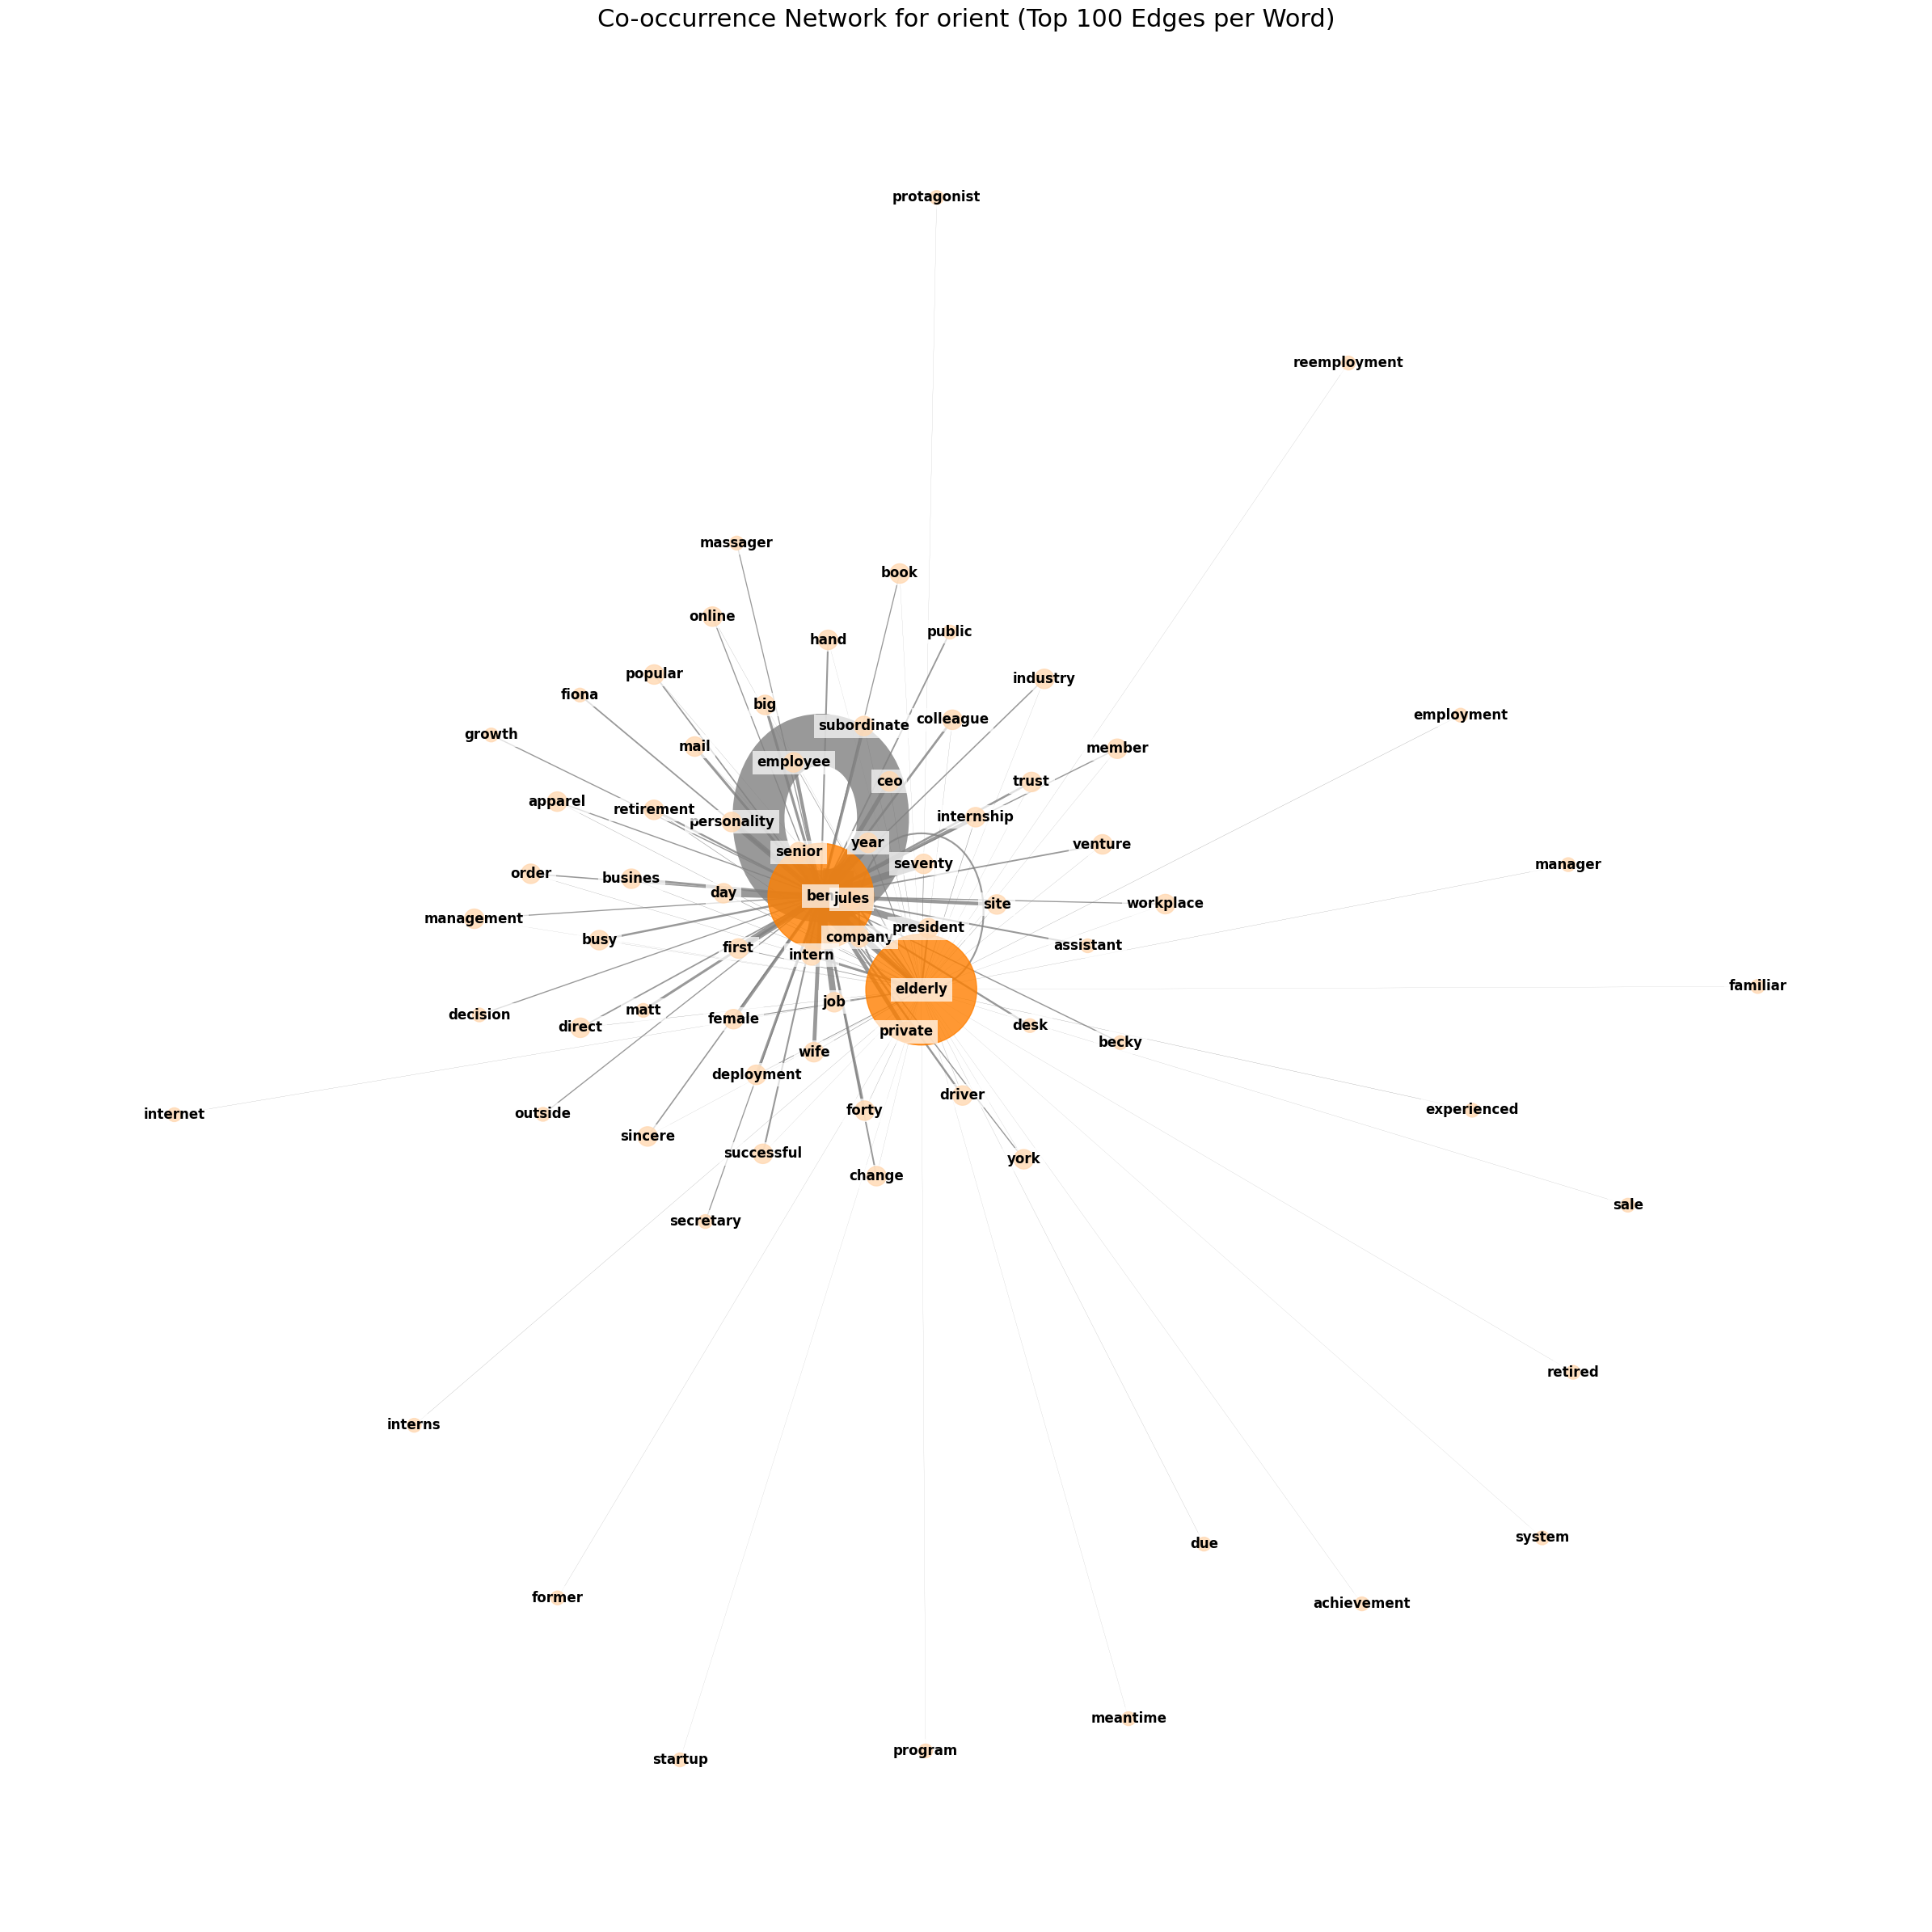

In [61]:
import itertools
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

co_occurrence = defaultdict(int)
top_weight= 100
window_size = 20

for sentence in modified_sentences_filtered:
    effective_window_size = min(len(sentence), window_size)
    for i in range(len(sentence)):
        window = sentence[i:i+effective_window_size]
        for pair in itertools.combinations(window, 2):
            co_occurrence[pair] += 1
            
# Create the graph
G = nx.MultiGraph()

for (word1, word2), weight in co_occurrence.items():
    G.add_edge(word1, word2, weight=weight)


relevant_words = df_dict[target_country]['representative_words']

filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if u in relevant_words or v in relevant_words]

H = nx.Graph()
H.add_edges_from(filtered_edges)

H_old_filtered = nx.Graph()

for word in relevant_words:
    edges_for_word = [(u, v, d) for u, v, d in G.edges(data=True) if (u == word or v == word)]
    sorted_edges = sorted(edges_for_word, key=lambda x: x[2]['weight'], reverse=True)[:top_weight]
    H_old_filtered.add_edges_from(sorted_edges)

# Visualization of the subgraph related to old words
plt.figure(figsize=(24,24))

# Adjust the spring layout for better node spacing
pos_old_filtered = nx.spring_layout(H_old_filtered, seed=42, k=1.2)

# Node sizes based on the number of edges (degree) connected to them
node_sizes = [H_old_filtered.degree(node) * 150 for node in H_old_filtered.nodes()]

# Node colors using HEX values (e.g., light blue)
node_colors = [f"#{df_dict[target_country]['color']}" for _ in H_old_filtered.nodes()]

# Draw edges with varying thickness based on weight
edge_weights = [d['weight'] for (u, v, d) in H_old_filtered.edges(data=True)]
max_weight = max(edge_weights)

normalized_weights = [50 * (w / max_weight) for w in edge_weights]

# Draw nodes, edges, and labels with improved readability
nx.draw_networkx_edges(H_old_filtered, pos_old_filtered, width=normalized_weights, alpha=0.8, edge_color='gray')
nx.draw_networkx_nodes(H_old_filtered, pos_old_filtered, node_size=node_sizes, node_color=node_colors, alpha=0.8)

# Add labels with a white background for better visibility
for node, (x, y) in pos_old_filtered.items():
    plt.text(x, y, node, fontsize=12, fontweight='bold', 
             ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title(f"Co-occurrence Network for {target_country} (Top {top_weight} Edges per Word)", fontsize=22)
plt.axis("off")
plt.tight_layout()
plt.show()

In [23]:
top_nodes

[('ben', 102),
 ('elderly', 102),
 ('senior', 101),
 ('older', 101),
 ('elder', 101),
 ('jules', 5),
 ('person', 5),
 ('old', 5),
 ('life', 5),
 ('company', 5),
 ('work', 5),
 ('intern', 5),
 ('young', 5),
 ('year', 5),
 ('president', 5),
 ('experience', 5),
 ('personality', 5),
 ('age', 5),
 ('relationship', 5),
 ('way', 5),
 ('seventy', 5),
 ('husband', 5),
 ('first', 5),
 ('job', 5),
 ('many', 5),
 ('new', 5),
 ('ceo', 5),
 ('family', 5),
 ('friend', 5),
 ('able', 5),
 ('different', 5),
 ('generation', 5),
 ('hard', 5),
 ('something', 5),
 ('great', 5),
 ('more', 5),
 ('wife', 5),
 ('busy', 5),
 ('best', 5),
 ('problem', 5),
 ('internship', 5),
 ('human', 5),
 ('everything', 5),
 ('own', 5),
 ('attitude', 5),
 ('someone', 4),
 ('heart', 4),
 ('day', 4),
 ('home', 4),
 ('female', 4)]

## 저장된 파일로 그래프 그리기

In [123]:
# STATIC_PATH = '저장폴더경로'

# JSON 파일에서 불러오기
def load_from_json(file_name):
    with open(os.path.join(STATIC_PATH,file_name), 'r', encoding='utf-8') as f:
        return json.load(f)


# 불러오기
loaded_data = load_from_json('ncfom_for_graph.json')

In [124]:
loaded_data[target_country].keys()

dict_keys(['color', 'representative_words', 'modified_sentences_filtered', 'relevant_words'])

In [128]:
top_num= 100
target_country = 'china'
modified_sentences_filtered = loaded_data[target_country]['modified_sentences_filtered']
relevant_words = loaded_data[target_country]['relevant_words']

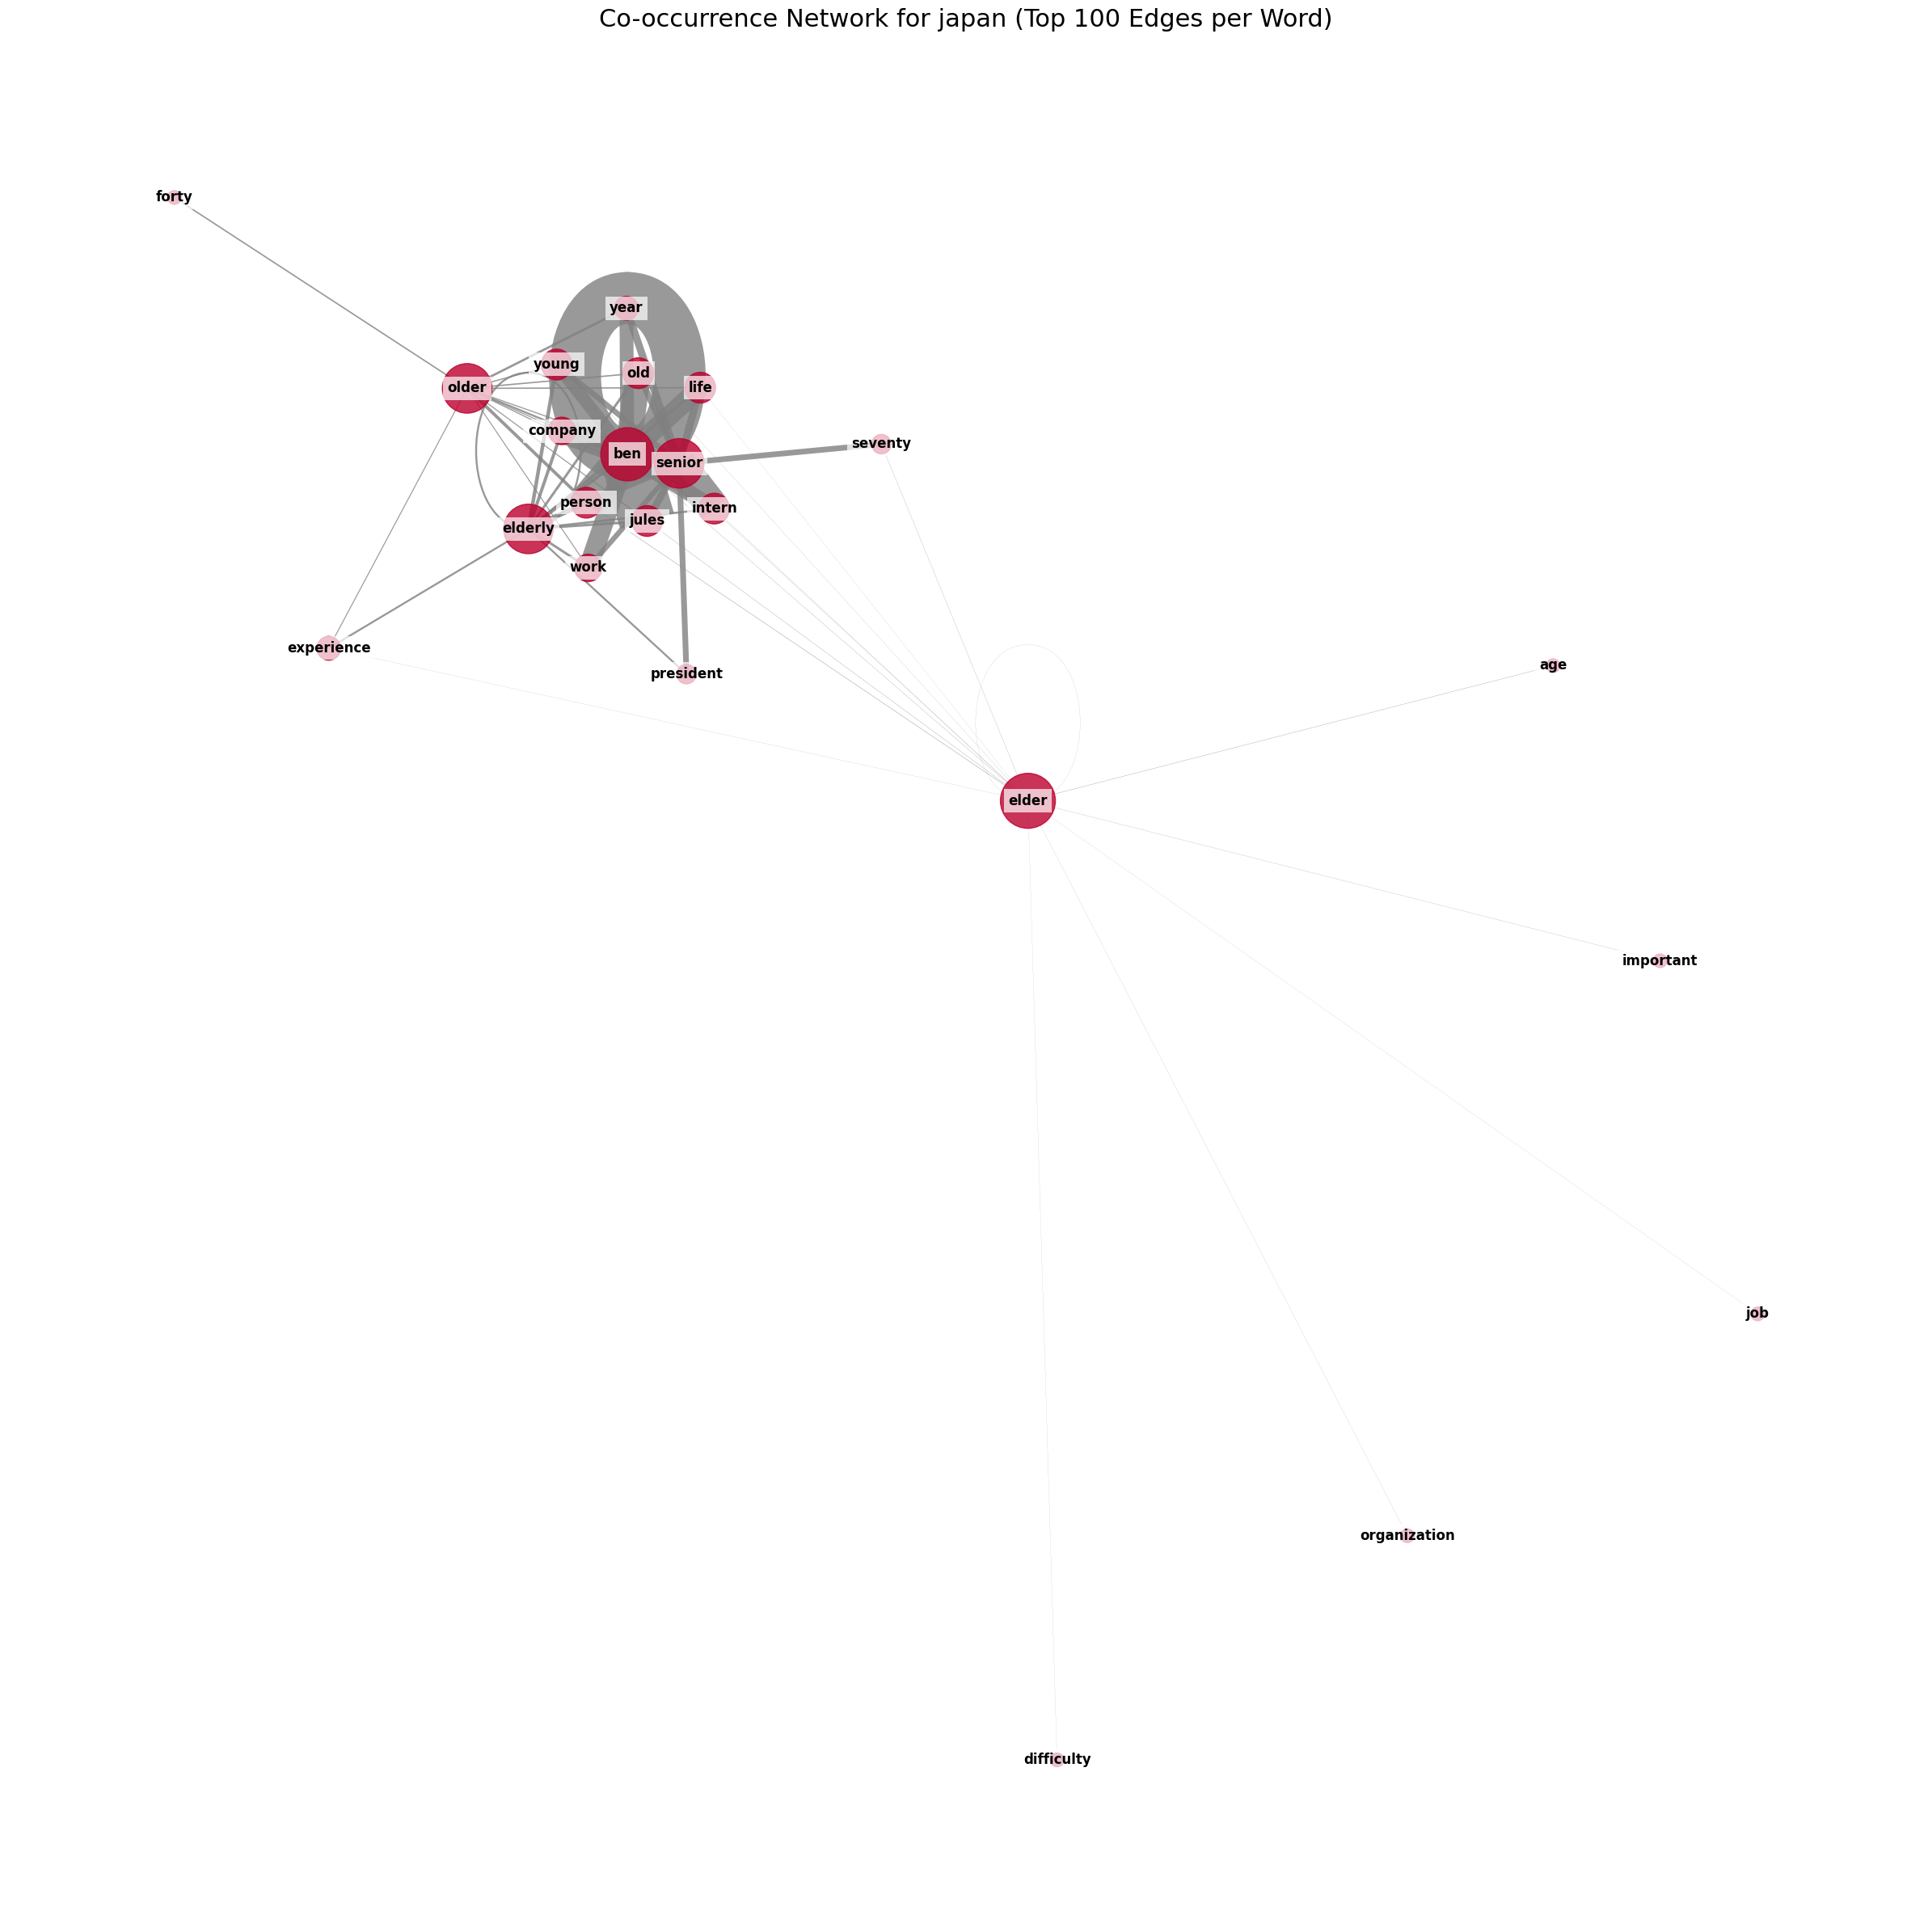

In [24]:
import itertools
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

co_occurrence = defaultdict(int)

window_size = 20

for sentence in modified_sentences_filtered:
    effective_window_size = min(len(sentence), window_size)
    for i in range(len(sentence)):
        window = sentence[i:i+effective_window_size]
        for pair in itertools.combinations(window, 2):
            co_occurrence[pair] += 1
            
# Create the graph
G = nx.MultiGraph()

for (word1, word2), weight in co_occurrence.items():
    G.add_edge(word1, word2, weight=weight)


# relevant_words = set(old_words + young_words)

filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if u in relevant_words or v in relevant_words]

H = nx.Graph()
H.add_edges_from(filtered_edges)

H_old_filtered = nx.Graph()

for word in relevant_words[:top_num]:
    edges_for_word = [(u, v, d) for u, v, d in G.edges(data=True) if (u == word or v == word)]
    sorted_edges = sorted(edges_for_word, key=lambda x: x[2]['weight'], reverse=True)[:20]
    H_old_filtered.add_edges_from(sorted_edges)

# Visualization of the subgraph related to old words
plt.figure(figsize=(24,24))

# Adjust the spring layout for better node spacing
pos_old_filtered = nx.spring_layout(H_old_filtered, seed=42, k=1.2)

# Node sizes based on the number of edges (degree) connected to them
node_sizes = [H_old_filtered.degree(node) * 150 for node in H_old_filtered.nodes()]

# Node colors using HEX values (e.g., light blue)
node_colors = [f"#{df_dict[target_country]['color']}" for _ in H_old_filtered.nodes()]

# Draw edges with varying thickness based on weight
edge_weights = [d['weight'] for (u, v, d) in H_old_filtered.edges(data=True)]
max_weight = max(edge_weights)
normalized_weights = [50 * (w / max_weight) for w in edge_weights]

# Draw nodes, edges, and labels with improved readability
nx.draw_networkx_edges(H_old_filtered, pos_old_filtered, width=normalized_weights, alpha=0.8, edge_color='gray')
nx.draw_networkx_nodes(H_old_filtered, pos_old_filtered, node_size=node_sizes, node_color=node_colors, alpha=0.8)

# Add labels with a white background for better visibility
for node, (x, y) in pos_old_filtered.items():
    plt.text(x, y, node, fontsize=12, fontweight='bold', 
             ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.title(f"Co-occurrence Network for {target_country} (Top {top_num} Edges per Word)", fontsize=22)
plt.axis("off")
plt.tight_layout()
plt.show()